### Read arcsix data using ict_utils.py

In [1]:
import sys
sys.path.append("/Users/C832577250/Research/SizeDistMerge/dev")

import numpy as np
import pandas as pd

from ict_utils import (read_aps, read_nmass, read_pops, read_uhsas, read_fims, read_inlet_flag,
    check_common_grid, filter_by_spectra_presence, mean_spectrum,)
from sizedist_utils import edges_from_mids_geometric, dvdlog_from_dndlog, dsdlog_from_dndlog, mids_from_edges, remap_dndlog_by_edges

# ============================ SIMPLE CONFIG ============================
start = "2024-06-11 16:00"
end   = "2024-06-11 16:10"

aps_dir   = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/LARGE-APS/"
nmass_dir = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/PUTLS-NMASS"
pops_dir  = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/PUTLS-POPS"
uhsas_dir = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/PUTLS-UHSAS"
fims_dir  = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/FIMS"
inlet_dir = "/Volumes/Hailstone Data/Research Data/ARCSIX_P3B/LARGE-InletFlag"

# ---------- helpers ----------
def edges_from_meta_or_mids(df: pd.DataFrame, mids_nm: np.ndarray) -> np.ndarray:
    meta = (df.attrs.get("bin_meta") or {})
    lo = meta.get("lower_nm")
    up = meta.get("upper_nm")
    if isinstance(lo, (list, tuple)) and isinstance(up, (list, tuple)) and len(lo) == len(up) and len(lo) > 0:
        return np.r_[np.asarray(lo, float), float(up[-1])]
    return edges_from_mids_geometric(mids_nm)

# ---------- read ----------
aps        = read_aps       (aps_dir,   start=start, end=end, prefix="ARCSIX")
nmass      = read_nmass     (nmass_dir, start=start, end=end, prefix="ARCSIX")
pops       = read_pops      (pops_dir,  start=start, end=end, prefix="ARCSIX")
uhsas      = read_uhsas     (uhsas_dir, start=start, end=end, prefix="ARCSIX")
fims       = read_fims      (fims_dir,  start=start, end=end, prefix="ARCSIX")
inlet_flag = read_inlet_flag(inlet_dir, start=start, end=end, prefix="ARCSIX")

frames = {"APS": aps, "POPS": pops, "UHSAS": uhsas, "FIMS": fims}
_ = check_common_grid(frames, ref_key="FIMS", round_to=None)

# ---------- optional presence filter ----------
fims_qc = pd.to_numeric(fims.get("QC_Flag", pd.Series(index=fims.index)), errors="coerce")
extra = {"FIMS": fims_qc.ne(2)}  # bad=2
filtered, _keep = filter_by_spectra_presence(
    frames, col_prefix="dNdlogDp",
    min_instruments=None,
    extra_masks=extra, treat_nonpositive_as_nan=False
)

# ---------- mean spectra + edges ----------
m_APS,   y_APS,   s_APS,   _ = mean_spectrum(aps,   "APS")
e_APS   = edges_from_meta_or_mids(aps,   m_APS)

m_POPS,  y_POPS,  s_POPS,  _ = mean_spectrum(pops,  "POPS")
e_POPS  = edges_from_meta_or_mids(pops,  m_POPS)

m_UHSAS, y_UHSAS, s_UHSAS, _ = mean_spectrum(uhsas, "UHSAS")
e_UHSAS = edges_from_meta_or_mids(uhsas, m_UHSAS)

m_FIMS,  y_FIMS,  s_FIMS,  _ = mean_spectrum(fims,  "FIMS")
e_FIMS = edges_from_meta_or_mids(fims,  m_FIMS)

# ---------- pack into specs ----------
specs = {
    "APS":   (m_APS,   e_APS,   y_APS,   s_APS),
    #"POPS":  (m_POPS,  e_POPS,  y_POPS,  s_POPS),
    "UHSAS": (m_UHSAS, e_UHSAS, y_UHSAS, s_UHSAS),
    "FIMS":  (m_FIMS,  e_FIMS,  y_FIMS,  s_FIMS),
}

# Example usage:
# mids, edges, mean, sigma  = specs["UHSAS"]

### Convert APS Sizes

In [2]:
from diameter_conversion_core import da_to_dv

rho_p_APS = 900
chi_t_APS = 1
edges_APS_dv = da_to_dv(e_APS, rho_p_APS, chi_t=chi_t_APS, rho0=1000.0)
m_APS_dv = mids_from_edges(edges_APS_dv)
y_APS_dv = remap_dndlog_by_edges(e_APS, edges_APS_dv, y_APS)
s_APS_dv = remap_dndlog_by_edges(e_APS, edges_APS_dv, s_APS)

specs[f'APS \u03C1={rho_p_APS}'] = (m_APS_dv, edges_APS_dv, y_APS_dv, s_APS_dv)


### Convert UHSAS sizes

In [ ]:
from optical_diameter_core import SigmaLUT, convert_do_lut, RI_UHSAS_SRC

lut_uhsas = SigmaLUT("/Users/C832577250/Research/SizeDistMerge/lut/uhsas_sigma_col_1054nm.zarr")
ri_uhsas = complex(1.4, 0.00)
edges_uhsas_newdo = convert_do_lut(e_UHSAS, ri_src=RI_UHSAS_SRC, ri_dst=ri_uhsas, lut=lut_uhsas)


SyntaxError: expected argument value expression (1930461270.py, line 5)

### Plot

<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
/var/folders/vs/_3jwdr4n263gxfx0y76wx93r0000gq/T/ipykernel_26224/1194803951.py:54: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("$\mathrm{d}V/\mathrm{d}\log D_p$  ($\mu\mathrm{m}^3\,\mathrm{cm}^{-3}$)")


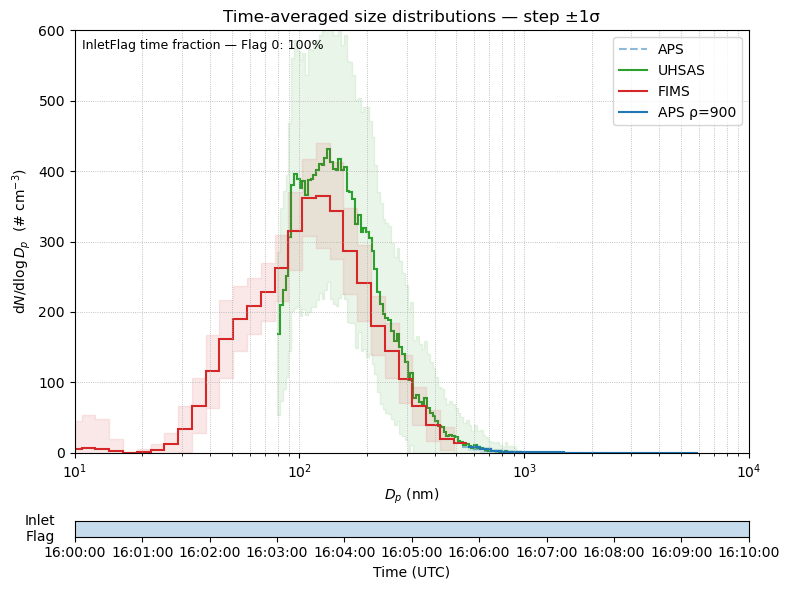

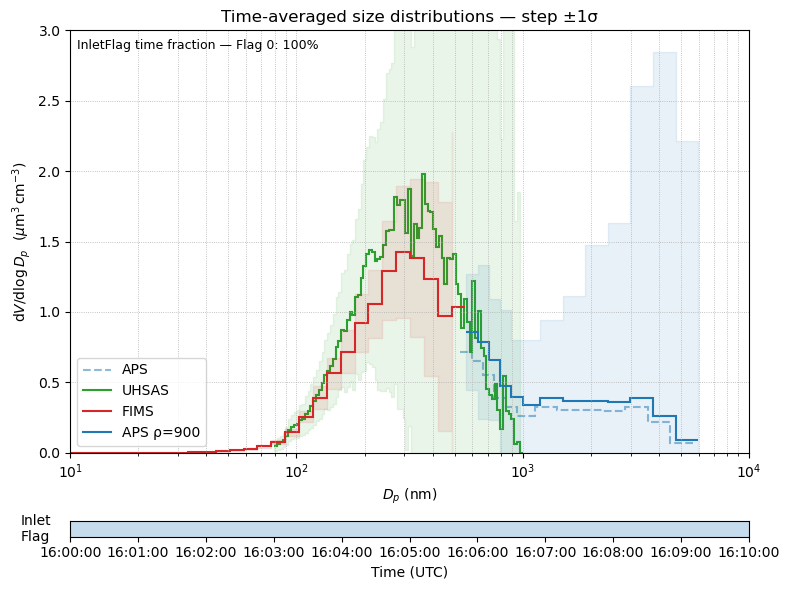

In [ ]:
import matplotlib.pyplot as plt
from sizedist_plot import plot_size_distributions, plot_size_distributions_steps

# ============================ PLOT CALL ============================
# You can adjust these plot settings
line_kwargs = {
    "_default": {"linewidth": 1.5},
    "APS":   {"color":"tab:blue", "alpha":0.5, 'ls':'dashed'},
    #"POPS":  {"color":"tab:orange"},
    "UHSAS": {"color":"tab:green"},
    "FIMS":  {"color":"tab:red"},
    f'APS \u03C1={rho_p_APS}':   {"color":"tab:blue"},
}

fill_kwargs = {
    "_default": {"alpha": 0.10},
    #"APS":   {"alpha":0.1,"color":"tab:blue"},
    "APS": False,  # disable fill for APS
    #"POPS":  {"alpha":0.1,"color":"tab:orange"},
    "UHSAS": {"alpha":0.1,"color":"tab:green"},
    "FIMS":  {"alpha":0.1,"color":"tab:red"},
    f'APS \u03C1={rho_p_APS}':   {"alpha":0.1,"color":"tab:blue"},
}

# --- plot step-style ---
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs,
    inlet_flag=inlet_flag,
    yscale="linear",          # or "log"
    xlim=(10, 1e4),
    ylim=(None, 600),                # None = autoscale
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True
)

# convert your specs (which are in dN/dlogDp) to dV/dlogDp
specs_V = {
    lab: (mids, edges,
          dvdlog_from_dndlog(mids, vals),
          dvdlog_from_dndlog(mids, sigma))
    for lab, (mids, edges, vals, sigma) in specs.items()
}

# then plot the volume distribution
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs_V,
    inlet_flag=inlet_flag,
    yscale="linear",
    xlim=(10, 1e4),
    ylim=(None, 3),
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True,
)

ax.set_ylabel("$\mathrm{d}V/\mathrm{d}\log D_p$  ($\mu\mathrm{m}^3\,\mathrm{cm}^{-3}$)")

plt.show()